# day08 - Black-box Variational Inference and the Score Function Trick

In this notebook, we'll cover

* Part 0: Recap of Variational Inference
* Part 1: Computing an ELBO via Monte-Carlo samples
* Part 2: The Problem with Gradients of the Monte Carlo ELBO
* Part 3: Score Function Trick
* Part 4: Gradients of the ELBO via the Score Function Trick
* Part 5: Example Implementation

# Prerequisites

Check out today's reading

* [Black-Box Variational Inference](https://arxiv.org/pdf/1601.00670.pdf) by Ranganath, Gerrish, and Blei
* * Esp. [Algorithm 1: BBVI](https://arxiv.org/pdf/1401.0118.pdf#page=3)
* [Blog post on the Score Function Trick](https://web.archive.org/web/20180303004918/http://blog.shakirm.com/2015/11/machine-learning-trick-of-the-day-5-log-derivative-trick/) by Shakir Mohamed

We'll try to use the same notation as in the BBVI paper

# Requirements

There are two ways to run this notebook

<table style="table-medium">
    <tr>
        <td style="align:left; text-align:left;"> <h2> Run in-browser (no install necessary) </h2>
        </td>
        <td style="align:left; text-align:left;"> <h2> Run locally on your computer </h2>
        </td>        
    </tr>
    <tr>
         <td style="align:left; text-align:left;">
             <p>You can use <a href="https://colab.research.google.com/">Google Colab </a> </p>
             <p>You'll need:</p>
             <ul>
             <li> internet connection </li>
             <li>  Modern browser (Firefox, Chrome, Safari, Edge, etc) </li>
             <li> Google account </li>
             <li> Warning: session will timeout after 12 hours, or sooner if inactive </li>
             <li> Plan to save work if you want it later </li>
         </ul></td>
         <td style="align:left; text-align:left;">
             <p>You can use <a href="https://jupyter.org/">Jupyter notebook </a> </p>
             <p>You'll need:</p>             <ul>
             <li> Linux, Mac OS or other modern Unix-based OS (sorry, Windows + JAX is difficult) </li>
             <li> Conda package manager </li>
             <li> Python 3.8+ </li>
             <li> All packages from <a href="https://www.cs.tufts.edu/comp/152BDL/2022f/bdl_2022f_env.html">bdl_2022f_env</a> 
                 , see <a href="https://www.cs.tufts.edu/comp/152BDL/2022f/setup_python_env.html">
                 Install Instructions on Course Website </a>
             </li>
         </ul></td>
    </tr>
</table>


In [1]:
# Import numpy and other basic libraries
import numpy as np
import pandas as pd
import time, os, platform

In [2]:
## Import JAX
import jax
import jax.numpy as jnp
import jax.scipy.stats as jstats

In [3]:
# Import packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

## Report OS and CPU information

In [4]:
uname = platform.uname()
B = 10
print("="*B, "Information about OS and CPU", "="*B)
print(f"Node Name: {uname.node}")
print(f"System: {uname.system}")
print(f"Version: {uname.version}")
print(f"Machine: {uname.machine}  Processor: {uname.processor}")
print("Num cores: ", os.cpu_count())

========== Information about OS and CPU ==========
Node Name: tufts-wifi-10-5-4-240.eecs.tufts.edu
System: Darwin
Version: Darwin Kernel Version 20.6.0: Tue Feb 22 21:10:41 PST 2022; root:xnu-7195.141.26~1/RELEASE_X86_64
Machine: x86_64  Processor: i386
Num cores:  8


## Report exact versions of required packages in local env

In [5]:
print("="*B, "Packages in local env", "="*B)
for pkg in [np, jax, matplotlib, sns]:
  print("%12s %s" % (pkg.__name__, pkg.__version__))

========== Packages in local env ==========
       numpy 1.22.4
         jax 0.3.17
  matplotlib 3.5.2
     seaborn 0.11.2


# Part 0: Recap of VI : Approximate Posterior Estimation via Optimization

In general, we're often interested in a model with two kinds of random variables

* $z$ : "hidden" parameters of the model, can never really be observed
* $x$ : observable data

The model is defined as a joint distribution $p(z, x) = p(z) p(x | z)$.

Given $N$ training observations $x_{1:N}$, we seek the posterior $p( z | x_{1:N} )$

We'd like to compute the posterior PDF $p(z | x_{1:N})$ directly, but it is **intractable** (we only know it up to a hard-to-compute normalization constant).

Instead, VI's purpose is to approximate the posterior. The essential idea of VI is that we want to solve a *tractable optimization problem* to estimate an *approximation* of the posterior.

We'll set up the problem by making two key design decisions:


* Pick a *simpler* family of distributions $q(z;\nu)$ over the same random variable $z$, parameterized by $\nu \in \mathcal{V}$

* Pick a suitable *cost function*, that for any $\nu \in \mathcal{V}$ scores how well the specific $q$ with parameter $\nu$ matches the target posterior $p(z | x_{1:N})$

Armed with these choices, we could then solve an optimization problem

\begin{align}
    \nu^* \gets \arg\!\min_{\nu \in \mathcal{V}} ~\text{cost}( q( z; \nu), p( z|x_{1:N}) )
\end{align}

We could then take $q$ with the optimal parameter $\nu^*$ as the (approximate) posterior!

* We could sample $z^s \sim q( \cdot ; \nu^*)$ and treat them like samples from the posterior
* We could evaluate the PDF $q( z | \nu^*)$ and treat it like a PDF of the posterior

The diagram below illustrates an **iterative solution** to the optimization problem above.

<img src="vi_diagram.png">

&nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Image Credit: [D. Blei's VI Tutorial](https://www.cs.columbia.edu/~blei/talks/Blei_VI_tutorial.pdf)

Previously, we learned that:

* Picking $q$ to be simple, well-understood density families like the Normal is often tractable
* Picking the cost function to be the KL divergence from $q$ to the true posterior is also tractable
* * This is because there's a related function, the ELBO, that if maximized is equivalent to minimizing KL

Today, we'll start to figure out how we can do *gradient-based optimization* for many different models using these assumptions.

# Part 1: Computing the ELBO via Monte Carlo samples

Recall that the objective we want to optimize is the ELBO

\begin{align}
\text{ELBO}(\nu; x_{1:N}) = \mathbb{E}_{q(z; \nu)} \left[ \log p(x_{1:N} | z) + \log \frac{p(z)}{q(z | \nu)} \right]
\end{align}

For some models, the expectations that define ELBO can be computed in closed form.

But in general, even if expectations are tough we can get an estimate via *Monte Carlo approximation* of the expectation

$$
\text{ELBO}(\nu; x_{1:N}) \approx \frac{1}{S}\sum_{s=1}^S \log p(x_{1:N} |z^s) + \log \frac{p(z^s) }{q(z^s)}
$$

where we've drawn $S$ independent samples $z^s \sim q(\cdot ; \nu)$.

In general, this is an **unbiased** estimate of the true ELBO. However, the error may be large if the number of samples $S$ is small.

Here, we need $q$ to be quite tractable, requiring both:

* ability to sample from $q$ to get the $z^s$
* ability to evaluate PDF of $q$ at any sampled value

# Part 2: A Problem with the Monte-Carlo ELBO: How to get Gradients?

The above lets us *evaluate* the ELBO objective function at a specific candidate parameter vector $\nu$.

However, the *goal* of VI is to estimate the posterior by solving the optimization problem

$$
\max_{\nu \in \mathcal{V}} \text{ELBO}(\nu; x_{1:N} )
$$

To solve this efficiently in high dimensions, we need to be able to apply **gradient ascent** (ascent because we're *maximizing* the ELBO). 

To do this, we need to take the gradient of the ELBO function with respect to the variational parameters $\nu$:

$$
\nabla_{\nu} \text{ELBO}( \nu; x_{1:N} )
$$

However, naively trying to apply a gradient operator to the MC approximation of the ELBO is problematic:

Consider the gradient of a 1-sample MC approximation, where the sample is $z^s \in \mathbb{R}$

\begin{align}
\nabla_{\nu} \left[ \log p( x_{1:N} | z^{s} ) + \log p( z^{s} ) - \log q( z^s ; \nu ) \right]
\end{align}

Hopefully this makes the problem clear: after we sample a concrete value of the random variable $z^s$, that value is treated as fixed and we've lost any functional dependence on $\nu$. However, in fact the random variable $z^s$ obviously *does* depend on $\nu$ because we sample $z^s \sim q( \cdot ; \nu)$.

# Part 3: Score Function Trick

Black-box VI (BBVI) by Ranganath and Blei offers one nice way to resolve the problem in Part 2. This solution makes use of a concept from statistical optimization

For any log pdf $q$ over any random variable $z$ with continuous parameter $\nu \in \mathcal{V}$, we can define a quantity known as a **score function**.

\begin{align}
\textbf{Definition:} 
\nabla_{\nu} \log q( z | \nu) ~\text{is the score function of $q$ wrt $\nu$}
\end{align}

This is called a "score" or "score function" for some historical reasons, going back to R. A. Fisher's work in the 1940s: See this stack overflow answer for more: https://stats.stackexchange.com/a/342374/13165

For our purposes, you just need to be able to learn some properties of the score function.


## Score function Trick, aka Log Derivative Trick, a useful identity via chain rule

Over and over again in statistics, the following useful identity can be found

\begin{align}
\nabla_{\nu} \log q(z | \nu) = \frac{1}{q(z|\nu)} \nabla_{\nu} q(z | \nu)
\end{align}

We've simply applied the gradient via the chain rule on the composition of $\log(\cdot)$ and $q(z|\nu)$

## Corrolary of Score Function Trick: Expected value of the score is *zero*

\begin{align}
\mathbb{E}_q[ \nabla_{\nu} \log q(z ; \nu) ]
    &= \mathbb{E}_q \left[ \frac{1}{q(z;\nu)} \nabla_{\nu} q(z ; \nu) \right] 
    \qquad && \text{by score function trick}
    \\
    &= \int_z q(z; \nu) \left[ \frac{1}{q(z;\nu)} \nabla_{\nu} q(z; \nu) \right] dz
    \qquad && \text{by defn of expectation}
    \\
    &= \int_z \nabla_{\nu} q(z; \nu) dz
    \qquad && \text{$q$ term in numerator and denominator cancel out}
    \\
    &= \nabla_{\nu} \left[ \int_z  q(z; \nu) dz \right]
    \qquad && \text{exchanging order of integral and derivative}
    \\
    &= \nabla_{\nu} \left[ 1 \right]
    \qquad && \text{integral of any pdf over its domain is 1 by defn}
    \\
    &= 0
    \qquad && \text{derivative of a constant}
\end{align}


Want more details about why exchanging the integral and derivative is valid? Shakir M's blog post points us to this paper: https://www.jstor.org/stable/2632893?seq=1



# Part 4: Gradient of the ELBO via Score Function Trick

## How is the score function trick helpful? Apply the trick to the ELBO!

\begin{align}
\nabla_{\nu} \text{ELBO}(\nu) 
    &= \nabla_{\nu} ~ \mathbb{E}_q \left[  \log p( x_{1:N}, z) - \log q(z;\nu) \right]
    \\
    &= \nabla_{\nu} ~ \int_z q(z;\nu) \left[  \log p( x_{1:N}, z) - \log q(z;\nu)  \right] dz
    \\
    &= \int_z  \nabla_{\nu} \left[ q(z;\nu) \left[  \log p( x_{1:N}, z) - \log q(z;\nu)  \right] \right] dz
    && \text{exchanging order of integral and derivative}
\end{align}

By the product rule of taking gradients, the inner gradient becomes

\begin{align}
   \nabla_{\nu} ~ \Bigg[ q(z;\nu) \left( \log p( x_{1:N}, z) - \log q(z;\nu)  \right) \Bigg]
      &= [ \nabla_{\nu} q(z;\nu) ] \cdot \left(  \log p( x_{1:N}, z) - \log q(z;\nu)  \right)
      \\
      & \quad + q(z;\nu) \left( \underbrace{\nabla_{\nu}[\log p(x_{1:N}, z)]}_{\text{zero bc const wrt $\nu$}} 
          - \underbrace{\nabla_{\nu}[ \log q(z;\nu)]}_{\text{zero bc expected score is always zero}} \right)
\end{align}

The second term here cancels to zero! Returning to the original expression, the gradient of our ELBO, we have

\begin{align}
\nabla_{\nu} \text{ELBO}(\nu) 
    &= \int_z  \nabla_{\nu} \left[ q(z;\nu) \left[  \log p( x_{1:N}, z) - \log q(z;\nu)  \right] \right] dz
    \\
    &= \int_z  
            [\nabla_{\nu} q(z;\nu) ] \cdot \left(  \log p( x_{1:N}, z) - \log q(z;\nu)  \right) dz
            && \text{applying inner gradient simplification above}
    \\ 
    &= \int_z  
            q(z;\nu) [\nabla_{\nu} \log q(z;\nu) ] \cdot \left(  \log p( x_{1:N}, z) - \log q(z;\nu)  \right) dz
            && \text{sub in score function trick}
    \\ 
    &= \mathbb{E}_q \Bigg[ [\nabla_{\nu} \log q(z;\nu) ] \cdot \left(  \log p( x_{1:N}, z) - \log q(z;\nu) \right) \Bigg]
    && \text{by defn of expectation}
\end{align}

Now, we have *another* expectation, this time one that is much easier to apply Monte Carlo approximation to

\begin{align}
\nabla_{\nu} \text{ELBO}(\nu) 
    \approx \frac{1}{S} \sum_{s=1}^S 
    [\nabla_{\nu} \log q(z^s;\nu) ] \cdot \left(  \log p( x_{1:N}, z^s) - \log q(z^s;\nu) \right)
\end{align}

## Sanity check: Dimensionality

The first term inside the sum, $\nabla_{\nu} \log q(z^s;\nu)$, will be a vector the same size as $\nu$.

The second term, the difference of the logpdf of $p$ and the logpdf of $q$, will be a scalar.

The product will thus be a vector of size $\nu$, which is what we need for a valid gradient wrt $\nu$


# Implementation Demo

We will create a "toy" dataset where there's a tough, non-Normal, multi-modal posterior

We will then show how to use VI to approximate this posterior, via various Gaussian approximations.

We'll use MC-estimated ELBO and check out the MC-estimated gradients using the score function trick.

### True model for y given x

Suppose we have a univariate features $x_i$ that are densely spaced within the interval (-3, 3).

We'll view the features as fixed, and draw the outputs $y$ via the following true model
$$
y_i \sim \mathcal{N}( x_i, 1)
$$

In [6]:
prng = np.random.RandomState(101)

true_tau = 1.0

N = 100

x_N = prng.uniform(size=N, low=-3, high=+3)

In [7]:
y_N = prng.normal(x_N, true_tau)

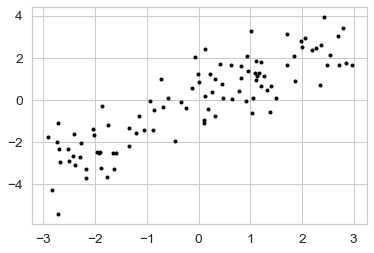

In [8]:
plt.plot(x_N, y_N, 'k.')

## Model : $p(z, y)$

\begin{align}
    z_1 &\sim \mathcal{N}(0, 1)
    \\
    z_2 &\sim \mathcal{N}(0, 1)
    \\
    y_i | z_1, z_2 &\sim \mathcal{N}( z_1 \cdot z_2 \cdot x_i, \tau^2)
\end{align}

In [9]:
class ToyModel:

    @classmethod
    def calc_logpdf_prior__S(self, z_SL):
        ''' Compute logpdf of prior at each of S samples of z
        
        Returns
        -------
        logpdf_S : 1D array, size (S,)
        '''
        return jnp.sum(jstats.norm.logpdf(z_SL, 0.0, 1.0), axis=1)
    
    @classmethod
    def calc_logpdf_likelihood__S(self, z_SL, y_N, x_N):
        ''' Compute logpdf of likelihood at each of S samples of z

        Returns
        -------
        logpdf_S : 1D array, size (S,)
        '''
        x_N1 = x_N[:,np.newaxis]
        prodz_1S = (z_SL[:,0] * z_SL[:,1])[jnp.newaxis,:]
        mean_NS = x_N1 * prodz_1S
        return jnp.sum(jstats.norm.logpdf(y_N[:,jnp.newaxis], mean_NS, 1.0), axis=0)

In [10]:
ToyModel.fast_logpdf_likelihood__S = jax.jit(ToyModel.calc_logpdf_likelihood__S)
ToyModel.fast_logpdf_prior__S = jax.jit(ToyModel.calc_logpdf_prior__S)

## Visualizing the posterior

In [11]:
G = 99
H = 101
z0_grid_G = np.linspace(-3, 3, G)
z1_grid_H = np.linspace(-3.1, 3.1, H)

z1_grid_GH, z0_grid_GH = np.meshgrid(z1_grid_H, z0_grid_G)
logpdf_posterior_GH = np.zeros((G,H))

z0_S1 = z0_grid_GH.flatten().reshape((G*H, 1))
z1_S1 = z1_grid_GH.flatten().reshape((G*H, 1))
z_S2 = np.hstack([z0_S1, z1_S1])
logpdf_post_S = (
    ToyModel.fast_logpdf_likelihood__S(z_S2, y_N, x_N)
    + ToyModel.fast_logpdf_prior__S(z_S2))
logpdf_post_GH = logpdf_post_S.reshape((G,H))

## View of unnormalized log posterior PDF, default settings for coloring

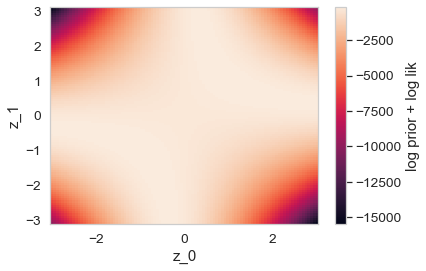

In [12]:
plt.pcolormesh(z0_grid_GH, z1_grid_GH, logpdf_post_GH)
plt.xlabel('z_0')
plt.ylabel('z_1')
plt.colorbar(label='log prior + log lik');

## View of unnormalized log posterior PDF, carefully-chosen settings for coloring

Key features to notice:

* Multimodal
* Not gaussian!

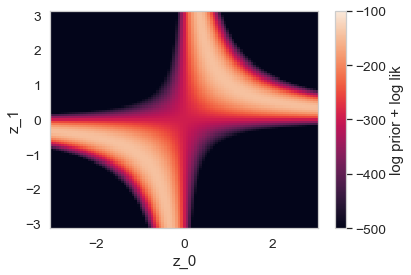

In [13]:
plt.pcolormesh(z0_grid_GH, z1_grid_GH, logpdf_post_GH, vmin=-500, vmax=-100)
plt.xlabel('z_0')
plt.ylabel('z_1')
plt.colorbar(label='log prior + log lik');

## Approx posterior family: Free means but fixed variance

In [14]:
class QNormalFixedVariance:

    fixed_stddev = np.sqrt(0.05)

    @classmethod
    def calc_sum_logpdf_q(self, z_SL, q_params):
        ''' Compute logpdf of q summed over S provided samples of z
        
        Returns
        -------
        logpdf : scalar float
        '''
        mu_L = q_params
        return jnp.sum(jstats.norm.logpdf(z_SL, mu_L[jnp.newaxis,:], self.fixed_stddev))
        
    @classmethod
    def calc_logpdf_q__S(self, z_SL, q_params, return_array=False):
        ''' Compute logpdf of q at each of S provided samples of z
        
        Returns
        -------
        logpdf : 1D array (S,)
        '''
        mu_L = q_params
        return jnp.sum(jstats.norm.logpdf(z_SL, mu_L[jnp.newaxis,:], self.fixed_stddev), axis=1)
        
    @classmethod
    def sample_z(self, q_params, random_state, n_samples=1):
        mu_L = q_params
        return random_state.normal(mu_L, self.fixed_stddev, size=(n_samples,) + mu_L.shape)
    
    @classmethod
    def initialize(self, z_shape, random_state=101):
        return np.zeros(z_shape)

In [15]:
QNormalFixedVariance.fast_logpdf_q__S = jax.jit(QNormalFixedVariance.calc_logpdf_q__S)

## Verify the gradient works (shape is correct)

In [16]:
nu_allzeros = QNormalFixedVariance.initialize((2,))

In [17]:
QNormalFixedVariance.calc_grad_of_logpdf_q = jax.grad(QNormalFixedVariance.calc_sum_logpdf_q, argnums=1)

In [18]:
val_and_grad = jax.value_and_grad(QNormalFixedVariance.calc_sum_logpdf_q, argnums=1)

In [19]:
z_SL = QNormalFixedVariance.sample_z(nu_allzeros, prng, n_samples=1)

In [21]:
val_and_grad(z_SL, nu_allzeros)

(DeviceArray(-1.4491026, dtype=float32),
 DeviceArray([ 9.076398, -4.679457], dtype=float32))

## ELBO calculation via MC approximation

We'll draw S samples of z from q, and use these to approximate the ELBO

In [22]:
def calc_ELBO_via_montecarlo(q_params, Model, Q, n_samples=100, random_state=np.random):
    z_SL = Q.sample_z(q_params, n_samples=n_samples, random_state=random_state)
    
    Eq_logpdf_lik_S = Model.fast_logpdf_likelihood__S(z_SL, y_N, x_N)
    Eq_logpdf_prior_S = Model.fast_logpdf_prior__S(z_SL)
    Eq_logpdf_q_S = Q.fast_logpdf_q__S(z_SL, q_params)
    
    elbo_S = Eq_logpdf_lik_S + Eq_logpdf_prior_S - Eq_logpdf_q_S
    return jnp.mean(elbo_S)

In [23]:
nu_allones = np.ones(2)

In [24]:
calc_ELBO_via_montecarlo(nu_allones, ToyModel, QNormalFixedVariance, n_samples=1000, random_state=prng)

DeviceArray(-160.04965, dtype=float32)

## Sanity check of the ELBO as a function of $\mu_1, \mu_2$

In [25]:
S = 1000

G = 99
H = 101
mu0_grid_G = np.linspace(-3, 3, G)
mu1_grid_H = np.linspace(-3.1, 3.1, H)

mu1_grid_GH, mu0_grid_GH = np.meshgrid(mu1_grid_H, mu0_grid_G)
elbo_GH = np.zeros((G,H))
for gg in range(G):
    for hh in range(H):
        q_params = np.asarray([mu0_grid_G[gg], mu1_grid_H[hh]])
        elbo_GH[gg, hh] = calc_ELBO_via_montecarlo(
            q_params, ToyModel, QNormalFixedVariance, n_samples=S, random_state=prng)

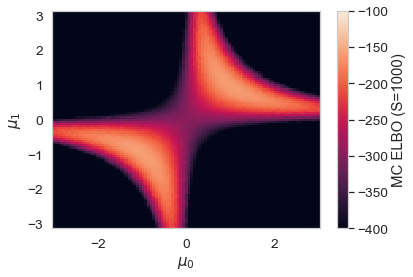

In [26]:
plt.pcolormesh(mu0_grid_GH, mu1_grid_GH, elbo_GH, vmin=-400, vmax=-100.)
plt.xlabel(r'$\mu_0$')
plt.ylabel(r'$\mu_1$')
plt.colorbar(label='MC ELBO (S=%d)' % (S));

## Gradient calculation, vectorized

In [27]:
def calc_grad_of_logpdf_q__SL(z_SL, nu_L):
    # Be sure to gradient wrt SECOND argument (index argnums=1)
    grad_wrt_nu = jax.grad(QNormalFixedVariance.calc_sum_logpdf_q, argnums=1)
    vectorized_grad_wrt_nu = jax.vmap(grad_wrt_nu)
    S = z_SL.shape[0]
    nu_SL = jnp.tile(nu_L, (S,1))
    return vectorized_grad_wrt_nu(z_SL, nu_SL)

QNormalFixedVariance.calc_grad_of_logpdf_q__SL = calc_grad_of_logpdf_q__SL

In [28]:
calc_grad_of_logpdf_q__SL(z_S2[:9], np.ones((2,)))

DeviceArray([[-80.00001 , -82.00001 ],
             [-80.00001 , -80.76001 ],
             [-80.00001 , -79.52001 ],
             [-80.00001 , -78.28001 ],
             [-80.00001 , -77.04001 ],
             [-80.00001 , -75.8     ],
             [-80.00001 , -74.560005],
             [-80.00001 , -73.32001 ],
             [-80.00001 , -72.08001 ]], dtype=float32)

## Gradient of the ELBO

In [29]:
def calc_grad_of_ELBO_via_montecarlo(q_params, Model, Q, n_samples=100, random_state=np.random):
    z_SL = Q.sample_z(q_params, n_samples=n_samples, random_state=random_state)
    
    Eq_logpdf_lik_S = Model.fast_logpdf_likelihood__S(z_SL, y_N, x_N)
    Eq_logpdf_prior_S = Model.fast_logpdf_prior__S(z_SL)
    Eq_logpdf_q_S = Q.fast_logpdf_q__S(z_SL, q_params)
    
    elbo_S = Eq_logpdf_lik_S + Eq_logpdf_prior_S - Eq_logpdf_q_S

    g_SL = QNormalFixedVariance.calc_grad_of_logpdf_q__SL(z_SL, q_params)
    
    return jnp.mean(g_SL * elbo_S[:,jnp.newaxis], axis=0)

### Try at nu = [1., 1.] which should be a local optima

In [30]:
nu_allones

array([1., 1.])

In [31]:
for rep in range(3):
    print(calc_grad_of_ELBO_via_montecarlo(nu_allones, ToyModel, QNormalFixedVariance, 10000, prng))

[-6.919244   2.0065045]
[ 4.178627 -8.215367]
[-8.689006 -8.941906]


## Try at nu = [3, 3]

In [32]:
3 * nu_allones

array([3., 3.])

In [33]:
for rep in range(3):
    print(calc_grad_of_ELBO_via_montecarlo(3 * nu_allones, ToyModel, QNormalFixedVariance, 10000, prng))

[-7272.7812 -6881.296 ]
[-7144.176 -7324.575]
[-6594.08   -6655.5044]


## Try at nu = [0.1, 0.1]

In [34]:
0.1 * nu_allones

array([0.1, 0.1])

In [35]:
for rep in range(3):
    print(calc_grad_of_ELBO_via_montecarlo(0.1 * nu_allones, ToyModel, QNormalFixedVariance, 10000, prng))

[24.31549   8.464051]
[34.289463 18.416159]
[18.72343  27.102524]
